In [43]:
#%reset
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef
from num2words import num2words
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score
import word2number
from word2number import w2n
from sklearn.tree import DecisionTreeClassifier
import pickle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
import random
from matplotlib.patches import Polygon
import seaborn as sns
from Functions import prep_training_test_data_period, prep_training_test_data, calculate_metrics,cross_validation_leave_geo_out, prep_training_test_data_shifted, add_labels_to_subplots, LOOCV_by_HSA_dataset, save_in_HSA_dictionary, prepare_data_and_model
hfont = {'fontname':'Helvetica'}
palette = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#e5c494']
palette_extended = sns.color_palette("husl", 13)
import pickle



# Load data

In [44]:
HSA_weekly_data_all = pd.read_csv("/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates_weekly.csv")

In [45]:
columns_to_select = HSA_weekly_data_all.filter(regex="HSA|beds_over_15_100k|weight").columns.tolist()
naive_data = HSA_weekly_data_all[columns_to_select]

# Polygons for mapping onto waves

In [46]:
## County Data 


data_by_county = pd.read_csv('/Users/rem76/Documents/COVID_projections/county_time_data_all_dates.csv')

data_by_county = data_by_county.dropna(subset=['admits_weekly', 'deaths_weekly', 'cases_weekly', 'icu_weekly', 'beds_weekly', 'perc_covid'])
data_by_county['CTYNAME'] = data_by_county['CTYNAME'].apply(lambda x: x.split()[0])
data_by_county['CTYNAME'] = data_by_county['fips'].astype(str) + '' + data_by_county['CTYNAME']
data_by_county['beds_over_15_100k'] = (data_by_county['beds_weekly'] > 15) * 1

# Redo dates
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i

## DELTA POLYGON 

start_date = pd.to_datetime('2021-06-30')
end_date = pd.to_datetime('2021-10-26')
data_by_county['date'] = pd.to_datetime(data_by_county['date'])
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i
# Find the indices of rows that match the exact start and end dates
matching_indices_start = data_by_county.loc[data_by_county['date'] <= start_date].index.max()
matching_indices_end = data_by_county.loc[data_by_county['date'] <= end_date].index.max()
first_week_delta = data_by_county.loc[matching_indices_start, 'week']
last_week_delta = data_by_county.loc[matching_indices_end, 'week']
start_date = pd.to_datetime('2021-10-26')
end_date = pd.to_datetime('2022-09-27')
data_by_county['date'] = pd.to_datetime(data_by_county['date'])
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i
# Find the indices of rows that match the exact start and end dates
matching_indices_start = data_by_county.loc[data_by_county['date'] <= start_date].index.max()
matching_indices_end = data_by_county.loc[data_by_county['date'] <= end_date].index.max()
first_week_omricon = data_by_county.loc[matching_indices_start, 'week']
last_week_omricon = data_by_county.loc[matching_indices_end, 'week']

## CDC POLYGON 
start_date = pd.to_datetime('2021-03-01')
end_date = pd.to_datetime('2022-01-24')
data_by_county['date'] = pd.to_datetime(data_by_county['date'])
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i
# Find the indices of rows that match the exact start and end dates
matching_indices_start = data_by_county.loc[data_by_county['date'] <= start_date].index.max()
matching_indices_end = data_by_county.loc[data_by_county['date'] <= end_date].index.max()
first_week_CDC = data_by_county.loc[matching_indices_start, 'week']
last_week_CDC = data_by_county.loc[matching_indices_end, 'week']

/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_6067/4200828156.py:4: DtypeWarning: Columns (47,48,49,50,51,55,56) have mixed types. Specify dtype option on import or set low_memory=False.
  data_by_county = pd.read_csv('/Users/rem76/Documents/COVID_projections/county_time_data_all_dates.csv')


# Percentage exceeding capacity 

In [47]:
percent_exceed_capacity = []

# Iterate through the columns of the DataFrame
for column_name in HSA_weekly_data_all.columns:
    if 'beds_over_15_100k' in column_name:
        # Calculate the sum of the column and append it to the list
        column_sum = HSA_weekly_data_all[column_name].sum()/len(HSA_weekly_data_all[column_name])
        percent_exceed_capacity.append(column_sum)

# Dictionaries to save data

In [48]:
model_metric_ROC = {}
model_metric_accuracy = {}
model_metric_MCC = {}

# Parameters for hyperparameter tuning 

In [49]:
no_iterations = 10
geography_column = 'HSA_ID'  
geo_split = 0.9  
time_period = 'period'  # Choose 'period', 'exact', or 'shifted'
size_of_test_dataset = 1

weeks_in_future = 3 
weight_col = 'weight'  
keep_output = True  
no_iterations_param = 100  # Replace with the number of iterations for RandomizedSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 5, 1),
    'min_samples_split': np.arange(200, 2000, 50), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(200, 2000, 50)} #100, 200, 300, 400, 500], #np.arange(500, 200)
    #'ccp_alpha': np.arange(0.0001, 0.0035, 0.0001) }

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations
weeks_to_predict_ten_week = range(1, 121 - 1 - 3 - 10)

# Naive expanding models

In [70]:
weeks_to_predict_expanding = range(1, 123 - size_of_test_dataset - 3 - 1)


In [84]:
#model_metric_ROC['ROC_by_week_naive_period'] = []
#model_metric_accuracy['accuracy_by_week_naive_period'] = []
#model_metric_MCC['norm_MCC_by_week_naive_period'] = []

#model_metric_ROC['ROC_by_week_naive_exact'] = []
#model_metric_accuracy['accuracy_by_week_naive_exact'] = []
#model_metric_MCC['norm_MCC_by_week_naive_exact'] = []

model_metric_ROC['ROC_by_week_naive_shifted'] = []
model_metric_accuracy['accuracy_by_week_naive_shifted'] = []
model_metric_MCC['norm_MCC_by_week_naive_shifted'] = []
keep_output = True  


size_of_test_dataset = 1
for prediction_week in weeks_to_predict_expanding:
    print(prediction_week)

    #period    

    X_train_naive, y_train_naive, weights_naive, missing_data_train_HSA = prep_training_test_data_period(naive_data, no_weeks=range(1, int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    X_test_naive, y_test_naive, weights_test_naive, missing_data_test_HSA = prep_training_test_data_period(naive_data, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    weights_naive = weights_naive[0].to_numpy()
    # no hyperparameter tuning as is the same irrespective of hyperparameters
    clf_naive = DecisionTreeClassifier( random_state=10, class_weight='balanced')
    clf_naive.fit(X_train_naive, y_train_naive, sample_weight=weights_naive)

    # Make predictions on the test set
    y_pred = clf_naive.predict(X_test_naive)
    y_pred_proba = clf_naive.predict_proba(X_test_naive)

    # Evaluate the accuracy of the model
    model_metric_ROC['ROC_by_week_naive_period'].append(roc_auc_score(y_test_naive, y_pred_proba[:, 1]))
    model_metric_accuracy['accuracy_by_week_naive_period'].append(accuracy_score(y_test_naive, y_pred))
    model_metric_MCC['norm_MCC_by_week_naive_period'].append((matthews_corrcoef(y_test_naive, y_pred) + 1)/2)

    # shifted
    X_train_naive_shifted, y_train_naive_shifted, weights_naive_shifted, missing_data_train_HSA = prep_training_test_data_shifted(naive_data, no_weeks=range(1 , int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    X_test_naive_shifted, y_test_naive_shifted, weights_test_naive_shifted, missing_data_test_HSA = prep_training_test_data_shifted(naive_data, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    weights_naive_shifted = weights_naive_shifted[0].to_numpy()
    # no hyperparameter tuning as it's the same irrespective of hyperparameters
    clf_naive = DecisionTreeClassifier(random_state=10, class_weight='balanced')
    clf_naive.fit(X_train_naive_shifted, y_train_naive_shifted, sample_weight=weights_naive_shifted)

    # Make predictions on the test set
    y_pred = clf_naive.predict(X_test_naive_shifted)
    y_pred_proba = clf_naive.predict_proba(X_test_naive_shifted)

    # Evaluate the accuracy of the model
    model_metric_ROC['ROC_by_week_naive_shifted'].append(roc_auc_score(y_test_naive_shifted, y_pred_proba[:, 1]))
    model_metric_accuracy['accuracy_by_week_naive_shifted'].append(accuracy_score(y_test_naive_shifted, y_pred))
    model_metric_MCC['norm_MCC_by_week_naive_shifted'].append((matthews_corrcoef(y_test_naive_shifted, y_pred) + 1)/2)




1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118


# Full expanding models

In [73]:
no_iterations = 10
geography_column = 'HSA_ID'  
geo_split = 0.9  
time_period = 'shifted'  # Choose 'period', 'exact', or 'shifted'
size_of_test_dataset = 1
train_weeks_for_initial_model = 1
weeks_in_future = 3 
weight_col = 'weight'  
keep_output = True  

no_iterations_param = 100  # Replace with the number of iterations for RandomizedSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 5, 1),
    'min_samples_split': np.arange(200, 2000, 50), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(200, 2000, 50)} #100, 200, 300, 400, 500], #np.arange(500, 200)
    #'ccp_alpha': np.arange(0.0001, 0.0035, 0.0001) }
weeks_to_predict_expanding = range(1, 123 - size_of_test_dataset - 3 - train_weeks_for_initial_model)

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

In [74]:

model_metric_ROC['ROC_by_week_full_shifted_expanding'] = []
model_metric_accuracy['accuracy_by_week_full_shifted_expanding'] = []
model_metric_MCC['norm_MCC_by_week_full_shifted_expanding'] = []


size_of_test_dataset = 1
for prediction_week in weeks_to_predict_expanding:
    model_name_to_load = "/Users/rem76/Documents/COVID_projections/Expanding_full_model_shifted/Full_model_shifted_NA/Full_model_" + time_period + "_" + str(prediction_week) + ".sav"
    clf_full_period = pickle.load(open(model_name_to_load, 'rb'))

    print(prediction_week)

    #period    

    X_train_full, y_train_full, weights_full, missing_data_train_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=range(1, int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

    X_test_full, y_test_full, weights_test_full, missing_data_test_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    weights_full = weights_full[0].to_numpy()
    clf_full_period.fit(X_train_full, y_train_full, sample_weight=weights_full)

    # Make predictions on the test set
    y_pred = clf_full_period.predict(X_test_full)
    y_pred_proba = clf_full_period.predict_proba(X_test_full)

    # Evaluate the accuracy of the model
    model_metric_ROC['ROC_by_week_full_shifted_expanding'].append(roc_auc_score(y_test_full, y_pred_proba[:, 1]))
    model_metric_accuracy['accuracy_by_week_full_shifted_expanding'].append(accuracy_score(y_test_full, y_pred))
    model_metric_MCC['norm_MCC_by_week_full_shifted_expanding'].append((matthews_corrcoef(y_test_full, y_pred) + 1)/2)



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117


# CDC A

In [75]:
keep_output = False  

model_metric_ROC['ROC_by_week_CDC_A_shifted_expanding'] = []
model_metric_accuracy['accuracy_by_week_CDC_A_shifted_expanding'] = []
model_metric_MCC['norm_MCC_by_week_CDC_shifted_A_expanding'] = []



size_of_test_dataset = 1
for prediction_week in weeks_to_predict_expanding:
    model_name_to_load ="/Users/rem76/Documents/COVID_projections/CDC_A/CDC_model"  

    print(prediction_week)

    #period    
    accuracy_period, roc_auc_period, mcc_period = prepare_data_and_model(HSA_weekly_data_all, weeks_in_future, geography_column, weight_col, keep_output,'period', model_name_to_load, prediction_week, size_of_test_dataset, train_weeks_for_initial_model)


    # Make predictions on the test set
    y_pred = clf_full_period.predict(X_test_full)
    y_pred_proba = clf_full_period.predict_proba(X_test_full)

    # Evaluate the accuracy of the model
    model_metric_ROC['ROC_by_week_CDC_A_shifted_expanding'].append(roc_auc_period)
    model_metric_accuracy['accuracy_by_week_CDC_A_shifted_expanding'].append(accuracy_period)
    model_metric_MCC['norm_MCC_by_week_CDC_shifted_A_expanding'].append(mcc_period)

    #accuracy_shifted, roc_auc_shifted, mcc_shifted = prepare_data_and_model(HSA_weekly_data_all, weeks_in_future, geography_column, weight_col, keep_output,'shifted', model_name, prediction_week, size_of_test_dataset, train_weeks_for_initial_model)





1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117


# CDC B

In [77]:
keep_output = True  

model_metric_ROC['ROC_by_week_CDC_B_shifted_expanding'] = []
model_metric_accuracy['accuracy_by_week_CDC_B_shifted_expanding'] = []
model_metric_MCC['norm_MCC_by_week_CDC_shifted_B_expanding'] = []



size_of_test_dataset = 1
for prediction_week in weeks_to_predict_expanding:
    model_name_to_load ="/Users/rem76/Documents/COVID_projections/CDC_B/CDC_model"

    print(prediction_week)

    #period    
    accuracy_period, roc_auc_period, mcc_period = prepare_data_and_model(HSA_weekly_data_all, weeks_in_future, geography_column, weight_col, keep_output,'period', model_name_to_load, prediction_week, size_of_test_dataset, train_weeks_for_initial_model)


    # Make predictions on the test set
    y_pred = clf_full_period.predict(X_test_full)
    y_pred_proba = clf_full_period.predict_proba(X_test_full)

    # Evaluate the accuracy of the model
    model_metric_ROC['ROC_by_week_CDC_B_shifted_expanding'].append(roc_auc_period)
    model_metric_accuracy['accuracy_by_week_CDC_B_shifted_expanding'].append(accuracy_period)
    model_metric_MCC['norm_MCC_by_week_CDC_shifted_B_expanding'].append(mcc_period)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117


# Calculate maximum regret (min-max loss)

In [78]:
def calculate_maximum_reget(metric, metrics_by_model, models, time_period, weeks_to_predict):
    metric_data = metrics_by_model[metric]

    maximum_regret_by_model = {model: [] for model in models}
    for j, prediction_week in enumerate(weeks_to_predict):
        best_metric = float('-inf') 
        for i, m in enumerate(metric_data): 
            m = list(metric_data.values())[i]
            model_metric = m[prediction_week]
            if model_metric >= best_metric:
                        best_metric = model_metric

        
        for i, m  in enumerate(metric_data): 
            m = list(metric_data.values())[i]
            model_metric = m[prediction_week]            
            model = models[i]
            if model_metric >= best_metric:
                    maximum_regret_by_model[model].append(0)
            else:
                    maximum_regret_by_model[model].append(best_metric - model_metric)   

    return maximum_regret_by_model

In [79]:
weeks_to_predict_expanding = range(1, 119)

Tidy dictionaries

In [80]:
all_metrics = {}
all_metrics['MCC'] = model_metric_MCC
all_metrics['ROC'] = model_metric_ROC
all_metrics['accuracy'] = model_metric_accuracy

models = ['Naive', 'Full', 'CDC A', 'CDC B',]

In [81]:
all_metrics['ROC'].keys()

dict_keys(['ROC_by_week_naive_period', 'ROC_by_week_full_period_expanding', 'ROC_by_week_CDC_A_period_expanding', 'ROC_by_week_CDC_B_period_expanding'])

In [82]:
maximum_regret_by_model_MCC =calculate_maximum_reget('MCC', all_metrics, models, time_period, weeks_to_predict_expanding)
maximum_regret_by_model_ROC =calculate_maximum_reget('ROC', all_metrics, models, time_period, weeks_to_predict_expanding)
maximum_regret_by_model_accuracy =calculate_maximum_reget('accuracy', all_metrics, models, time_period, weeks_to_predict_expanding)

IndexError: list index out of range

Plot maximum regret

In [ ]:
palette_extended = ['#77CCB1', '#E78964', '#8da0cb', '#e5c494' , '#e5c494', '#FFED66']


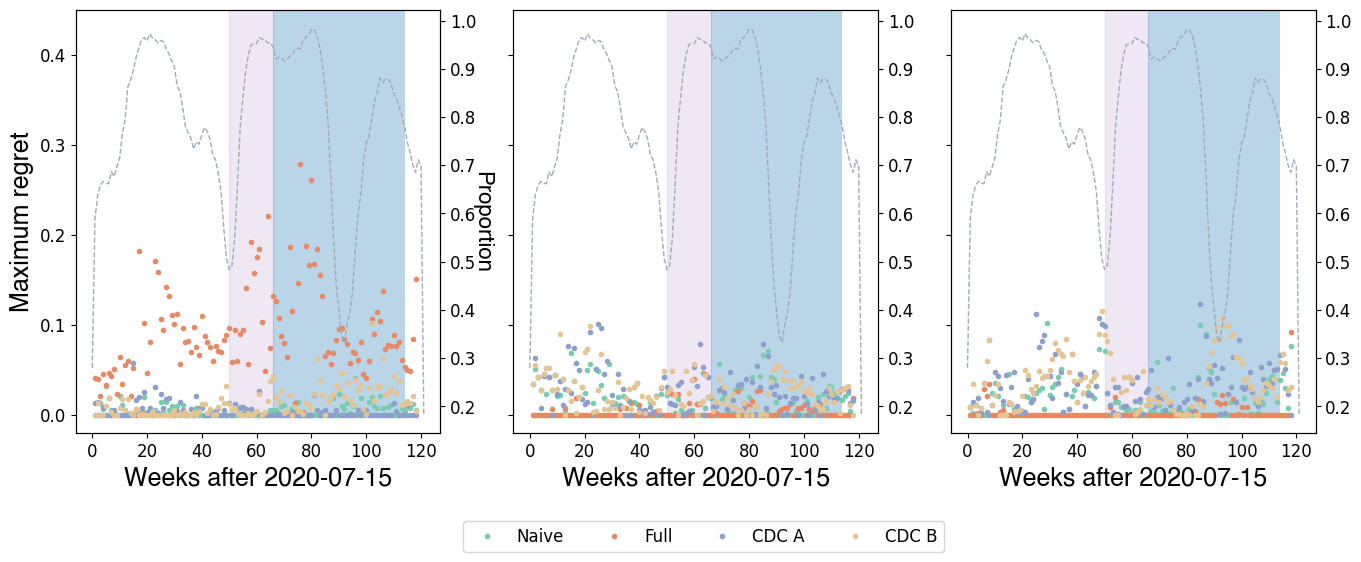

In [ ]:
# Create a figure and subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 5.5), sharey = 'all')
second_axs = [ax.twinx() for ax in axs]

for i, model in enumerate(models):
    axs[0].plot(weeks_to_predict_expanding, maximum_regret_by_model_ROC[model], label=model, marker = '.', linestyle = '', color = palette_extended[i])
second_axs[0].plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, linewidth = 1, color = '#A0AABA', linestyle = '--')

for i, model in enumerate(models):
    axs[1].plot(weeks_to_predict_expanding, maximum_regret_by_model_MCC[model], label=model, marker = '.', linestyle = '', color = palette_extended[i])
second_axs[1].plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, linewidth = 1, color = '#A0AABA', linestyle = '--', label = 'Prop. HSAs exceeding threshold')

for i, model in enumerate(models):
    axs[2].plot(weeks_to_predict_expanding, maximum_regret_by_model_accuracy[model], label=model, marker = '.', linestyle = '', color = palette_extended[i])
second_axs[2].plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, linewidth = 1, color = '#A0AABA', linestyle = '--')

# Add labels and legend
for i in range(len(axs)):
    axs[i].set_xlabel('Weeks after 2020-07-15',**hfont,  fontsize = 18 )
    axs[i].tick_params(axis='both', which='major', labelsize=12)
    second_axs[i].tick_params(axis='both', which='major', labelsize=12)
    polygon_delta = Polygon([(first_week_delta, 0), (first_week_delta, 100000), (last_week_delta, 100000), (last_week_delta, 0)],
                      alpha=0.3, color = '#cdb4db')
    axs[i].add_patch(polygon_delta)
    polygon_omricon = Polygon([(first_week_omricon, 0), (first_week_omricon, 100000), (last_week_omricon, 100000), (last_week_omricon, 0)],
                        alpha=0.3)
    axs[i].add_patch(polygon_omricon)

second_axs[0].set_ylabel('Proportion',**hfont, rotation=-90, fontsize = 16,  labelpad=11)
axs[0].set_ylabel('Maximum regret',**hfont,  fontsize = 18)
axs[0].set_ylim(-.02,.45)
#add_labels_to_subplots(axs, hfont, 1.01, 24)
axs[1].legend(ncol = 4, loc='lower left', bbox_to_anchor=(-.16, -.30), fontsize='12')
#plt.savefig(f'/Users/rem76/Documents/COVID_projections/COVID_forecasting/Graphs/Maximum_regret_three_week_shifted_comparison_test_{size_of_test_dataset}_week.png', dpi = 300, bbox_inches="tight")

KeyError: 'Naive'

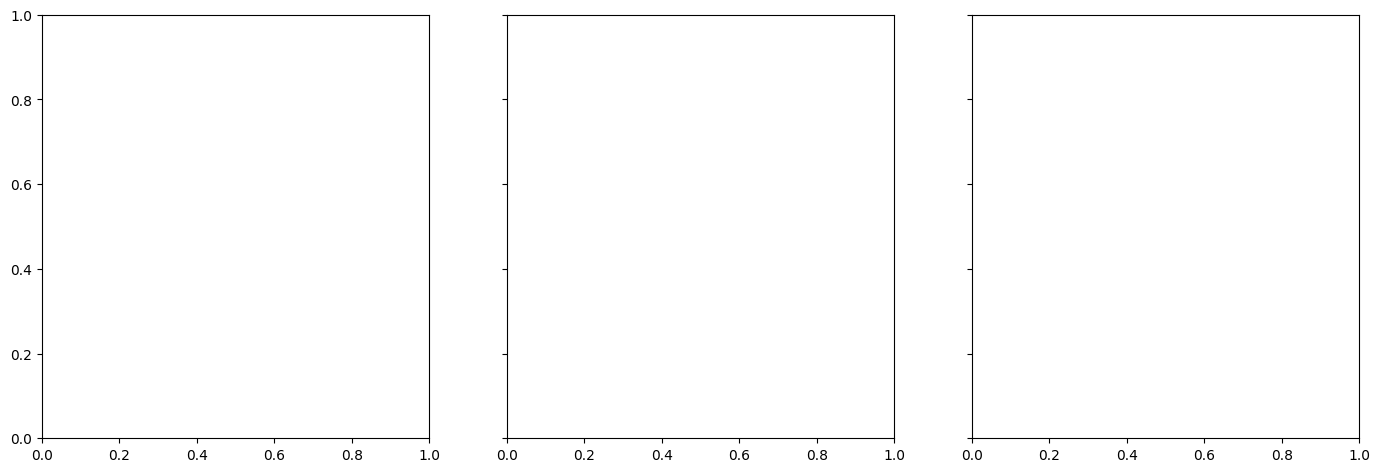

In [ ]:
# Create a figure and subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(17, 5.5), sharey = 'all')
axs = axs.ravel()
axs[0].plot(weeks_to_predict_expanding, all_metrics['ROC']['Naive'], label='Naive', linewidth = 2, color = palette[0])
axs[0].plot(weeks_to_predict_expanding,  all_metrics['ROC']['Full'], label='Full', linewidth = 2, color = palette[1])
axs[0].plot(weeks_to_predict_expanding,  all_metrics['ROC']['CDC A'], label='CDC A', linewidth = 2, color = palette[2])
axs[0].plot(weeks_to_predict_expanding,  all_metrics['ROC']['CDC B'], label='CDC B', linewidth = 2, color = palette[3])

axs[0].plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, linewidth = 1, color = '#A0AABA', linestyle = '--', label = 'Prop. HSAs exceeding threshold')
axs[0].set_title("auROC",fontsize=20)

axs[1].plot(weeks_to_predict_expanding,  all_metrics['MCC']['Naive'], label='Naive', linewidth = 2, color = palette[0])
axs[1].plot(weeks_to_predict_expanding,  all_metrics['MCC']['Full'], label='Full', linewidth = 2, color = palette[1])
axs[1].plot(weeks_to_predict_expanding,  all_metrics['MCC']['CDC A'], label='CDC A', linewidth = 2, color = palette[2])
axs[1].plot(weeks_to_predict_expanding,  all_metrics['MCC']['CDC B'], label='CDC B', linewidth = 2, color = palette[3])
axs[1].plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, linewidth = 1, color = '#A0AABA', linestyle = '--')
axs[1].set_title("Normalized MCC",fontsize=20)

axs[2].plot(weeks_to_predict_expanding, all_metrics['accuracy']['Naive'], label='Naive', linewidth = 2, color = palette[0])
axs[2].plot(weeks_to_predict_expanding, all_metrics['accuracy']['Full'], label='Full', linewidth = 2, color = palette[1])
axs[2].plot(weeks_to_predict_expanding, all_metrics['accuracy']['CDC A'], label='CDC A', linewidth = 2, color = palette[2])
axs[2].plot(weeks_to_predict_expanding, all_metrics['accuracy']['CDC B'], label='CDC B', linewidth = 2, color = palette[3])
axs[2].plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, linewidth = 1, color = '#A0AABA', linestyle = '--')
axs[2].set_title("Accuracy",fontsize=20)
# Add labels and legend

axs[0].set_ylabel('Performance score',**hfont,  fontsize = 18)

add_labels_to_subplots(axs, hfont, 1.01, 24)
axs[0].legend(ncol = 2, loc='lower left')

plt.tight_layout()
for ax in axs:
    ax.set_xlabel('Weeks after 2020-07-15',**hfont,  fontsize = 18 )
    ax.tick_params(axis='both', which='major', labelsize=14)

    polygon_delta = Polygon([(first_week_delta, 0), (first_week_delta, 100000), (last_week_delta, 100000), (last_week_delta, 0)],
                      alpha=0.3, color = '#cdb4db')
    ax.add_patch(polygon_delta)
    polygon_omricon = Polygon([(first_week_omricon, 0), (first_week_omricon, 100000), (last_week_omricon, 100000), (last_week_omricon, 0)],
                      alpha=0.3)
    ax.add_patch(polygon_omricon)
plt.tight_layout()